# Plots Comparing Regrets of Different Policy Ranking Methods

In [1]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
with open("../data/invalid_policy_list.json") as f:
    invalid_policies = json.load(f)["invalid_policies"]
def filter_policy_map(policy_map):
    ret_data = {}
    for policy in policy_map:
        if is_policy_valid(policy):
            ret_data[policy] = policy_map[policy]
    return ret_data

def is_policy_valid(policy_name):
    if "blind" in policy_name or policy_name in invalid_policies:
        return False
    else:
        return True
    
def convert_to_df(policy_map, col_names=["policy","zone","score"]):
    ret_df = pd.DataFrame(columns=col_names)
    for policy in policy_map:
        for zone in policy_map[policy]:
            score = policy_map[policy][zone]
            ret_df.loc[len(ret_df)] = [policy, zone, score]
    return ret_df

In [3]:
raw_scores_locs = {
    "UCB: 1-Day Eval": "data/ucb_raw_scores_19_07_2022.pkl",
    "ZCP: Grad-Norm (15)": "data/grad_norm_raw_scores_16_06_2022.pkl",
    "ZCP: Grad-Norm (30)": "data/grad_norm_raw_scores_30_days_16_07_2022.pkl",
    "ZCP: SNIP (15)": "data/snip_raw_scores_16_06_2022.pkl",
    "ZCP: SNIP (30)": "data/snip_raw_scores_30_days_16_07_2022.pkl",
    "ZCP: Jacob-Cov (15)": "data/jacob_cov_raw_scores_16_06_2022.pkl",
    "ZCP: Jacob-Cov (30)": "data/jacob_cov_raw_scores_30_days_16_07_2022.pkl",
    "ZCP: Synflow (15)": "data/synflow_raw_scores_15_days_16_07_2022.pkl",
    "ZCP: Synflow (30)": "data/synflow_raw_scores_30_days_16_07_2022.pkl",
    "OPE: IPW (30)": "data/ipw_scores_14_06_2022.pkl",
    "OPE: IPW (15)": "data/ipw_raw_scores_11_07_2022.pkl",
    "OPE: SNIPW (15)": "data/snipw_raw_scores_15_days_15_07_2022.pkl",
    "OPE: SNIPW (30)": "data/snipw_raw_scores_30_days_15_07_2022.pkl"
}

raw_scores = {}
for method, loc in tqdm(raw_scores_locs.items()):
    with open(loc, "rb") as f:
        policy_map = pickle.load(f)
        raw_scores[method] = convert_to_df(filter_policy_map(policy_map))

validation_data_loc = "../data/1month_eval.csv"
eval_df = pd.read_csv(validation_data_loc, header=None, names=["datetime","policy","zone","energy"])
eval_df_new = pd.DataFrame(columns=eval_df.columns)
for i, row in eval_df.iterrows():
    if is_policy_valid("../"+row["policy"]):
        eval_df_new.loc[len(eval_df_new)] = row
eval_df = eval_df_new

  0%|          | 0/13 [00:00<?, ?it/s]

## Regret For Policies Across all Zones

In [12]:
def calc_simple_regret(prediction, ground_truth, method):
    ground_truth = ground_truth.sort_values(by=["energy"])
    max_delta = max(ground_truth["energy"]) - min(ground_truth["energy"])
    
    if method.split(" ")[1] in ["Synflow"]:
        ascending = True
    elif method.split(" ")[1] in ["Grad-Norm", "SNIP", "Jacob-Cov", "IPW", "SNIPW", "1-Day"]:
        ascending = False
    prediction = prediction.sort_values(by=["score"], ascending=ascending)
    
    
    best_policy_prediction = prediction["policy"].values[0][3:]

    best_score_ground_truth = ground_truth["energy"].values[0]
    predicted_best_policy_score = ground_truth[ground_truth["policy"] == best_policy_prediction]["energy"].values[0]
    regret = -best_score_ground_truth + predicted_best_policy_score
    return regret / max_delta

def calc_regret_at_k(prediction, ground_truth, method, k=5):
    ground_truth = ground_truth.sort_values(by=["energy"], ascending=True)
    max_delta = max(ground_truth["energy"]) - min(ground_truth["energy"])
    
    if method.split(" ")[1] in ["Synflow"]:
        ascending = True
    elif method.split(" ")[1] in ["Grad-Norm", "SNIP", "Jacob-Cov", "IPW", "SNIPW", "1-Day"]:
        ascending = False
    prediction = prediction.sort_values(by=["score"], ascending=ascending)
    # prediction = prediction.sort_values(by=["score"])
    
    top_k_preds = prediction[:k]
    top_k_policies = []
    top_k_actual_vals = []
    for i, row in top_k_preds.iterrows():
        top_k_policies.append(row["policy"])
        policy = row["policy"][3:]
        actual_value = ground_truth[ground_truth["policy"] == policy]["energy"].values[0]
        top_k_actual_vals.append(actual_value)
    
    best_score_ground_truth = ground_truth["energy"].values[0]
    best_predicted_value_top_k = min(top_k_actual_vals)
    regret_at_k = -best_score_ground_truth + best_predicted_value_top_k
        
    return regret_at_k / max_delta

In [13]:
K = 5
dfs = []
for method in raw_scores:
    print(method)
    df = pd.DataFrame()
    methods = []
    regrets = []
    regrets_at_k = []
    for zone in eval_df["zone"].unique():
        zone_eval_df = eval_df[eval_df["zone"] == zone]
        zone_metric_df = raw_scores[method][raw_scores[method]["zone"] == zone]
        regret = calc_simple_regret(zone_metric_df, zone_eval_df, method)
        regret_at_k = calc_regret_at_k(zone_metric_df, zone_eval_df, method, k=K)
        methods.append(method)
        regrets.append(regret)
        regrets_at_k.append(regret_at_k)
    df["method"] = methods
    df["regret"] = regrets
    df["regret_at_k"] = regrets_at_k
    dfs.append(df.copy())
plot_df = pd.concat(dfs)

UCB: 1-Day Eval
ZCP: Grad-Norm (15)
ZCP: Grad-Norm (30)
ZCP: SNIP (15)
ZCP: SNIP (30)
ZCP: Jacob-Cov (15)
ZCP: Jacob-Cov (30)
ZCP: Synflow (15)
ZCP: Synflow (30)
OPE: IPW (30)
OPE: IPW (15)
OPE: SNIPW (15)
OPE: SNIPW (30)


/Users/aakashsasikumar/.pyenv/versions/3.10.0/envs/ep_policy_diversity/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'UCB: 1-Day Eval'),
  Text(1, 0, 'ZCP: Grad-Norm (15)'),
  Text(2, 0, 'ZCP: Grad-Norm (30)'),
  Text(3, 0, 'ZCP: SNIP (15)'),
  Text(4, 0, 'ZCP: SNIP (30)'),
  Text(5, 0, 'ZCP: Jacob-Cov (15)'),
  Text(6, 0, 'ZCP: Jacob-Cov (30)'),
  Text(7, 0, 'ZCP: Synflow (15)'),
  Text(8, 0, 'ZCP: Synflow (30)'),
  Text(9, 0, 'OPE: IPW (30)'),
  Text(10, 0, 'OPE: IPW (15)'),
  Text(11, 0, 'OPE: SNIPW (15)'),
  Text(12, 0, 'OPE: SNIPW (30)')])

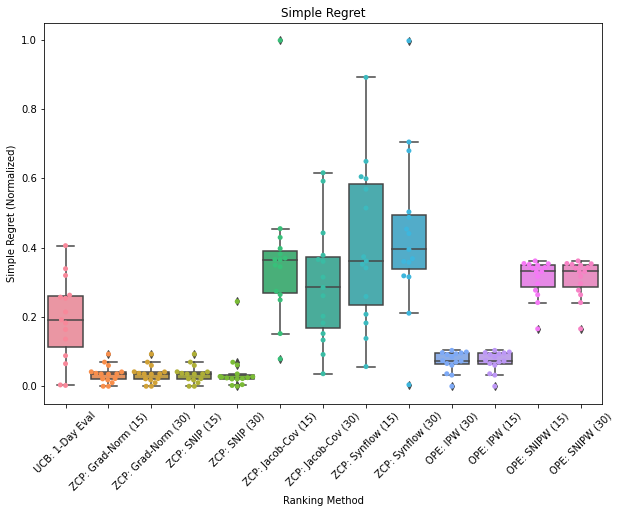

In [14]:
plt.figure(figsize=(10, 7))
plt.title("Simple Regret")
sns.boxplot(x="method", y="regret", data=plot_df)
sns.swarmplot(x="method", y="regret", data=plot_df)
plt.xlabel("Ranking Method")
plt.ylabel("Simple Regret (Normalized)")
plt.xticks(rotation=45)
# plt.savefig("plots/simple_regret_17_07_2022.png", dpi=300, bbox_inches="tight")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'UCB: 1-Day Eval'),
  Text(1, 0, 'ZCP: Grad-Norm (15)'),
  Text(2, 0, 'ZCP: Grad-Norm (30)'),
  Text(3, 0, 'ZCP: SNIP (15)'),
  Text(4, 0, 'ZCP: SNIP (30)'),
  Text(5, 0, 'ZCP: Jacob-Cov (15)'),
  Text(6, 0, 'ZCP: Jacob-Cov (30)'),
  Text(7, 0, 'ZCP: Synflow (15)'),
  Text(8, 0, 'ZCP: Synflow (30)'),
  Text(9, 0, 'OPE: IPW (30)'),
  Text(10, 0, 'OPE: IPW (15)'),
  Text(11, 0, 'OPE: SNIPW (15)'),
  Text(12, 0, 'OPE: SNIPW (30)')])

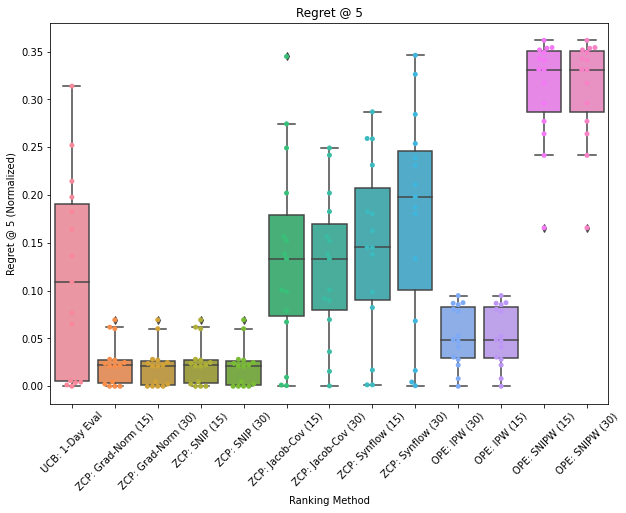

In [15]:
plt.figure(figsize=(10, 7))
plt.title(f"Regret @ {K}")
sns.boxplot(x="method", y="regret_at_k", data=plot_df)
sns.swarmplot(x="method", y="regret_at_k", data=plot_df)
plt.xlabel("Ranking Method")
plt.ylabel(f"Regret @ {K} (Normalized)")
plt.xticks(rotation=45)
# plt.savefig("plots/regret@5_17_07_2022.png", dpi=300, bbox_inches="tight")